# Semi-supervised DCGAN on SVHN

In [1]:
%matplotlib inline

import os
import cv2
import pickle
import hashlib
import zipfile
import glob
from tqdm import tqdm
from urllib.request import urlretrieve
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!mkdir chck

## Get SVHN data

In [ ]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Test existence of data
train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
test_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
data_path = '../data'
train_file = 'train_32x32.mat'
test_file = 'test_32x32.mat'
train_path = os.path.join(data_path, train_file)
test_path = os.path.join(data_path, test_file)

exists = {
    'train_mat_file': os.path.exists(train_path),
    'test_mat_file': os.path.exists(test_path)
}

if not os.path.exists(train_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(train_url, train_path, pbar.hook)

if not os.path.exists(test_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Test Set') as pbar:
        urlretrieve(test_url, test_path, pbar.hook)

In [ ]:
class Dataset():
    def __init__(self, train_path, test_path, mask_len=1000):        
        trainset = loadmat(train_path)
        testset = loadmat(test_path)
        # Reorder axis
        trainset['X'] = np.rollaxis(trainset['X'], 3)
        testset['X'] = np.rollaxis(testset['X'], 3)
        # Set lengths
        trainlen = trainset['X'].shape[0]
        testlen = testset['X'].shape[0]
        # Scale data
        trainset['X'] = self.scale(trainset['X'])
        testset['X'] = self.scale(testset['X'])
        # Shuffle data
        ii = np.arange(trainlen)
        np.random.shuffle(ii)
        trainset['X'] = trainset['X'][ii,:]
        trainset['y'] = trainset['y'][ii,:]
        # Label mask
        label_mask = np.zeros_like(trainset['y'])
        label_mask[:mask_len] = 1
        label_mask = label_mask[ii]
        
        self.datadict = {
            'train': { 'X': trainset['X'], 'y': trainset['y'], 'mask': label_mask },
            'test': { 'X': testset['X'][:int(testlen//2),:], 'y': testset['y'][:int(testlen//2),:] },
            'valid': { 'X': testset['X'][int(testlen//2):,:], 'y': testset['y'][int(testlen//2):,:] },
        }
        self.imshape = self.datadict['train']['X'][0,:].shape        
        
    def scale(self, x, value_range=(-1, 1)):
        # scale to (0, 1)
        x = ((x - x.min())/(x.max() - x.min()))    
        # scale to value_range
        min, max = value_range
        x = x * (max - min) + min
        return x
    
    def num_examples(self, which_set='train'):
        return self.datadict[which_set]['X'].shape[0]

    def gen_batches(self, batch_size, which_set='train'):
        batchx = np.zeros(shape=(batch_size, *self.imshape), dtype=np.float)
        batchy = np.zeros(shape=(batch_size, ), dtype=np.float)
        batchmask = np.zeros(shape=(batch_size, ), dtype=np.float)
        image_index = 0
        
        while True:
            for batch_index in range(batch_size):
                batchx[batch_index, :] = self.datadict[which_set]['X'][image_index]
                batchy[batch_index] = self.datadict[which_set]['y'][image_index]
                if which_set == 'train':
                    batchmask[batch_index] = self.datadict[which_set]['mask'][image_index]
                else:
                    batchmask[batch_index] = 1
                image_index = (image_index + 1) % self.datadict[which_set]['X'].shape[0]
            
            if which_set == 'train':
                yield batchx, batchy, batchmask
            else:
                yield batchx, batchy, batchmask

In [ ]:
def view_samples(samples):
    nrows = samples.shape[0]
    ncols = samples.shape[1]
    
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(1.5*ncols,1.5*nrows))
    for ir in range(nrows):
        axrow = axes[ir] if nrows>1 else axes
        for ic in range(ncols):
            img = np.reshape((samples[ir, ic, :]+1)/2.0, (32, 32, 3))
            axrow[ic].imshow(img, aspect='equal')
            axrow[ic].xaxis.set_visible(False)
            axrow[ic].yaxis.set_visible(False)
            axrow[ic].tick_params(which='both', 
                    bottom='off', top='off', left='off', right='off', 
                    labelbottom='off', labeltop='off', labelleft='off', labelright='off')
            axrow[ic].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
batch_size = 25
svhn = Dataset(train_path, test_path)

In [ ]:
train_batches = svhn.gen_batches(batch_size, which_set='train')
test_batches = svhn.gen_batches(batch_size, which_set='test')
valid_batches = svhn.gen_batches(batch_size, which_set='valid')

In [ ]:
# Display a batch of images
batchx, batchy, batchmask = next(train_batches)
batchx = np.reshape(batchx, (5, 5, *batchx.shape[1:]))
view_samples(batchx)


## Build network

In [ ]:
import tensorflow.contrib.layers as tfcl

class DCGAN():
    def __init__(self, num_classes=10, gnlayers=4, dnlayers=4, alpha=0.2, beta1=0.5, smooth=0.99, build=True):
        # sizes
        self.io_shape = (32, 32, 3)
        self.z_shape = (100, )
        self.num_classes = num_classes
        self.gnlayers = gnlayers
        self.dnlayers = dnlayers
        self.alpha = alpha
        self.beta1 = beta1
        self.smooth = smooth
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, *self.io_shape], name='input')
        self.z = tf.placeholder(tf.float32, shape=[None, *self.z_shape], name='z')
        self.y = tf.placeholder(tf.int32, shape=[None], name='y')
        self.label_mask = tf.placeholder(tf.float32, shape=[None], name='label_mask')
        self.lr = tf.placeholder(tf.float32, name='learning_rate')
            
    def generator(self, i, nlayers=4, output_dim=3, training=True, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            layer = tfcl.fully_connected(i, 4 * 4 * nlayers * 4, activation_fn=None)
            
            layer = tf.reshape(layer, (-1, 4, 4, nlayers * 4))
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            
            layer = tfcl.conv2d_transpose(layer, num_outputs=nlayers * 2, kernel_size=5, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)

            layer = tfcl.conv2d_transpose(layer, num_outputs=nlayers, kernel_size=5, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)

            layer = tfcl.conv2d_transpose(layer, num_outputs=output_dim, kernel_size=5, stride=2, padding='SAME')
            
            out = tf.tanh(layer)            
            return out
        
    def discriminator(self, X, nlayers=4, nclasses=10, training=True, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            layer = tfcl.dropout(X, keep_prob=0.9)
            
            layer = tfcl.conv2d(X, num_outputs=nlayers, kernel_size=3, stride=2, padding='SAME')
            layer = tf.maximum(self.alpha*layer, layer)
            layer = tfcl.dropout(layer, keep_prob=0.8)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers, kernel_size=3, stride=1, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(self.alpha*layer, layer)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(self.alpha*layer, layer)
            layer = tfcl.dropout(layer, keep_prob=0.8)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers*2, kernel_size=3, stride=1, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(self.alpha*layer, layer)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers*2, kernel_size=3, stride=1, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(self.alpha*layer, layer)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers*4, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(self.alpha*layer, layer)
            layer = tfcl.dropout(layer, keep_prob=0.8)
            
            layer = tfcl.conv2d(layer, num_outputs=nlayers*4, kernel_size=3, stride=1, padding='VALID')
            layer = tf.maximum(self.alpha*layer, layer)
            features = tf.reduce_mean(layer, (1, 2))
            
            logits = tfcl.fully_connected(features, nclasses+1, activation_fn=None)
            prob = tf.nn.softmax(logits)
            
            real_logits, fake_logit = tf.split(logits, [nclasses, 1], axis=1)
            fake_logit = tf.squeeze(fake_logit)
            
            max_real = tf.reduce_max(real_logits, axis=1, keep_dims=True)
            stable_real_logits = real_logits - max_real
            gan_logit = tf.squeeze(max_real) - fake_logit + \
                            tf.log(tf.reduce_sum(tf.exp(stable_real_logits), axis=1))
            
            return prob, logits, gan_logit, features      
            
    def build(self):
        self.placeholders()
        
        self.sample = self.generator(self.z, nlayers=self.gnlayers, output_dim=3, training=True, reuse=False)
        # Discriminator on generated samples
        fake_prob, fake_logits, fake_gan_logit, fake_features = \
            self.discriminator(self.sample, nlayers=self.dnlayers, nclasses=10, training=True, reuse=False)
        # Discriminator on real samples
        real_prob, real_logits, real_gan_logit, real_features = \
            self.discriminator(self.input, nlayers=self.dnlayers, nclasses=10, training=True, reuse=True)
        
        # Discriminator loss
        dloss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_gan_logit, labels=tf.zeros_like(fake_gan_logit))
        dloss_real = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=real_gan_logit, labels=tf.ones_like(real_gan_logit)*self.smooth)
        dloss_class = tf.nn.softmax_cross_entropy_with_logits(
            logits=real_logits, labels=tf.one_hot(self.y, self.num_classes + 1, dtype=tf.float32))
        dloss_class = dloss_class * self.label_mask
        
        self.dloss = tf.reduce_mean(dloss_fake + dloss_real) + \
                    tf.reduce_sum(dloss_class)/tf.maximum(1.0, tf.reduce_sum(self.label_mask))
            
        # Generator loss
        fake_features_mean = tf.reduce_mean(fake_features, axis=0)
        real_features_mean = tf.reduce_mean(real_features, axis=0)
        
        self.gloss = tf.reduce_mean(tf.abs(fake_features_mean - real_features_mean))
        
        # Compute accuracy
        predicted = tf.cast(tf.argmax(real_logits, axis=1), tf.int32)
        eq = tf.to_float(tf.equal(predicted, self.y))
        self.correct = tf.reduce_sum(eq)
        self.masked_correct = tf.reduce_sum(self.label_mask * eq)
        
        # Trainable parameters
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        
        self.train_discriminator = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(self.dloss, var_list=dvars)
        self.train_generator = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(self.gloss, var_list=gvars)
           
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)

In [2]:
import tensorflow.contrib.layers as tfcl

class DCGAN2():
    def __init__(self, num_classes=10, gnlayers=4, dnlayers=4, alpha=0.2, beta1=0.5, smooth=0.99, build=True):
        # sizes
        self.io_shape = (32, 32, 3)
        self.z_shape = (100, )
        self.num_classes = num_classes
        self.gnlayers = gnlayers
        self.dnlayers = dnlayers
        self.alpha = alpha
        self.beta1 = beta1
        self.smooth = smooth
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, *self.io_shape], name='input')
        self.z = tf.placeholder(tf.float32, shape=[None, *self.z_shape], name='z')
        self.y = tf.placeholder(tf.int32, shape=[None, 1], name='y')
        self.label_mask = tf.placeholder(tf.int32, shape=[None, 1], name='label_mask')
        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        
    def generator(self, z, size_mult=128, output_dim=3, reuse=False, alpha=0.2, training=True):
        with tf.variable_scope('generator', reuse=reuse):
            # First fully connected layer
            x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
            # Reshape it to start the convolutional stack
            x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
            x1 = tf.layers.batch_normalization(x1, training=training)
            x1 = tf.maximum(alpha * x1, x1)
        
            x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
            x2 = tf.layers.batch_normalization(x2, training=training)
            x2 = tf.maximum(alpha * x2, x2)
        
            x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
            x3 = tf.layers.batch_normalization(x3, training=training)
            x3 = tf.maximum(alpha * x3, x3)
            
            # Output layer
            logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')            
            out = tf.tanh(logits)
        
            return out
        
    def discriminator(self, x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
        with tf.variable_scope('discriminator', reuse=reuse):
            x = tf.layers.dropout(x, rate=drop_rate/2.5)
        
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
            x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * x2, x2)
                
            x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
            x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
            bn4 = tf.layers.batch_normalization(x4, training=True)
            relu4 = tf.maximum(alpha * bn4, bn4)
        
            x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
            bn5 = tf.layers.batch_normalization(x5, training=True)
            relu5 = tf.maximum(alpha * bn5, bn5)
        
            x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
            bn6 = tf.layers.batch_normalization(x6, training=True)
            relu6 = tf.maximum(alpha * bn6, bn6)
            relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        
            x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
            relu7 = tf.maximum(alpha * x7, x7)
        
            # Flatten it by global average pooling
            features = tf.reduce_mean(relu7, (1, 2))
        
            # Set class_logits to be the inputs to a softmax distribution over the different classes
            class_logits = tf.layers.dense(features, num_classes + 1)

            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        
            mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
            stable_real_class_logits = real_class_logits - mx

            gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
            out = tf.nn.softmax(class_logits)
        
            return out, class_logits, gan_logits, features 
            
    def build(self):
        self.placeholders()
            
        g_size_mult = 32
        d_size_mult = 64
    
        # Here we run the generator and the discriminator
        self.samples = self.generator(self.z, output_dim=3, alpha=self.alpha, size_mult=g_size_mult)
        d_on_data = self.discriminator(self.input, alpha=self.alpha, drop_rate=self.drop_rate, size_mult=d_size_mult)
        d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
        d_on_samples = self.discriminator(self.samples, reuse=True, alpha=self.alpha, drop_rate=self.drop_rate, size_mult=d_size_mult)
        d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
        
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data,
                                                labels=tf.ones_like(gan_logits_on_data)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples,
                                                labels=tf.zeros_like(gan_logits_on_samples)))
        y = tf.squeeze(self.y)
        class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data,
                                                                  labels=tf.one_hot(y, self.num_classes + 1,
                                                                                    dtype=tf.float32))
        class_cross_entropy = tf.squeeze(class_cross_entropy)
        label_mask = tf.squeeze(tf.to_float(self.label_mask))
        d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1., tf.reduce_sum(label_mask))
        self.d_loss = d_loss_class + d_loss_real + d_loss_fake
    
        data_moments = tf.reduce_mean(data_features, axis=0)
        sample_moments = tf.reduce_mean(sample_features, axis=0)
        self.g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))

        pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
        eq = tf.equal(tf.squeeze(y), pred_class)
        self.correct = tf.reduce_sum(tf.to_float(eq))
        self.masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        for t in t_vars:
            assert t in d_vars or t in g_vars

        # Minimize both players' costs simultaneously
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        self.d_train_opt = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1).minimize(self.d_loss, var_list=d_vars)
        self.g_train_opt = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1).minimize(self.g_loss, var_list=g_vars)
        self.shrink_lr = tf.assign(self.learning_rate, self.learning_rate * 0.9)    

    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)

In [ ]:
batch_size = 128
svhn = Dataset(train_path, test_path, mask_len=1000)
train_batches = svhn.gen_batches(batch_size, which_set='train')
test_batches = svhn.gen_batches(batch_size, which_set='test')
valid_batches = svhn.gen_batches(batch_size, which_set='valid')

In [3]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:1000] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [4]:
data_dir = '../data/'
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Epoch 0
		Classifier train accuracy:  0.097
		Classifier test accuracy 0.109787953288
		Step time:  0.18346881866455078
		Epoch time:  65.35153722763062


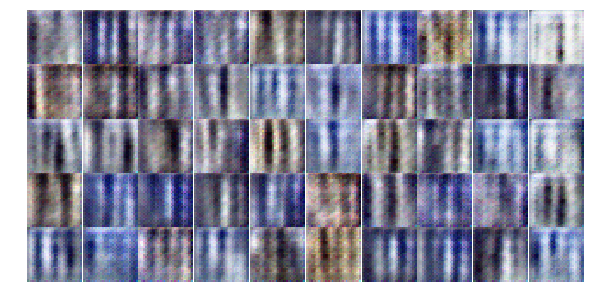

Epoch 1
		Classifier train accuracy:  0.135
		Classifier test accuracy 0.114935464044
		Step time:  0.10470151901245117
		Epoch time:  66.63583636283875


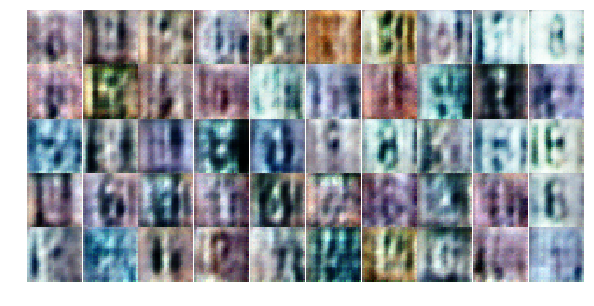

Epoch 2
		Classifier train accuracy:  0.168
		Classifier test accuracy 0.142901044868
		Step time:  0.09508180618286133
		Epoch time:  72.2665627002716


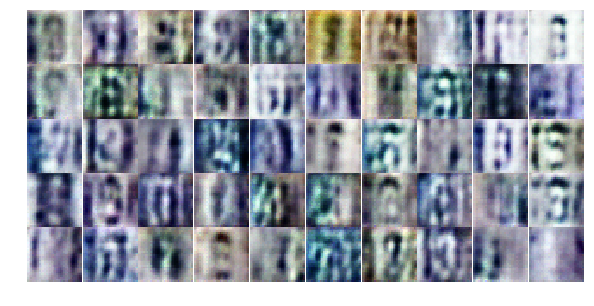

Epoch 3
		Classifier train accuracy:  0.3
		Classifier test accuracy 0.327596803934
		Step time:  0.10174322128295898
		Epoch time:  72.70906734466553


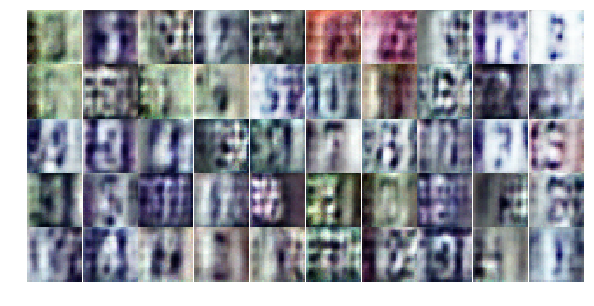

NameError: name 'pkl' is not defined

In [5]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

import time
def train(net, dataset, epochs, batch_size, figsize=(5,5)):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            print("Epoch",e)
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_train_opt, net.g_train_opt, net.masked_correct],
                                         feed_dict={net.input: x, net.z: batch_z,
                                                    net.y : y, net.label_mask : label_mask})
                t2 = time.time()
                num_correct += correct

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print("\t\tClassifier train accuracy: ", train_accuracy)
            
            num_examples = 0
            num_correct = 0
            for x, y in dataset.batches(batch_size, which_set="test"):
                assert 'int' in str(y.dtype)
                num_examples += x.shape[0]

                correct, = sess.run([net.correct], feed_dict={net.input: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.})
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print("\t\tClassifier test accuracy", test_accuracy)
            print("\t\tStep time: ", t2 - t1)
            t2e = time.time()
            print("\t\tEpoch time: ", t2e - t1e)
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples


# Train the model and save it
z_size = 100
learning_rate = 0.0003
nepochs = 4

tf.reset_default_graph()
model = DCGAN2(gnlayers=32, dnlayers=64)

dataset = Dataset(trainset, testset)

batch_size = 128
epochs = nepochs
train_accuracies, test_accuracies, samples = train(model, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
# Train the model and save it
nepochs = 4
display_every = 1000
restore_model = False # False, True
learning_rate = 0.0003

tf.reset_default_graph()
if restore_model:    
    model = DCGAN2(gnlayers=32, dnlayers=64, build=False)    
else:
    model = DCGAN2(gnlayers=32, dnlayers=64)
    with open('chck/semi_dcgan_svhn.pickle', 'wb') as f:
        pickle.dump(model.gc, f)

with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/semi_dcgan_svhn.meta')
        saver.restore(sess, "chck/semi_dcgan_svhn")
        with open('chck/semi_dcgan_svhn.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = svhn.num_examples('train')+svhn.num_examples('test')
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        dloss, gloss = 0.0, 0.0
        train_accuracies, test_accuracies = [], []
        samples = []
        for epoch in range(nepochs):
            # Optimize using train set
            # Log train accuracy
            label_count, correct_count = 0, 0
            for batch_idx in range(int(svhn.num_examples('train')//batch_size)):
                # Image batch
                batchx, batchy, batchmask = next(train_batches)
                # Noise batch
                noise_batch = np.random.normal(0.0, 1.0, size=(batch_size, *model.z_shape))
                # Run optimizers
                _, _, correct = sess.run(
                    [model.d_train_opt, model.g_train_opt, model.masked_correct],
                    feed_dict={model.input: batchx, model.z: noise_batch, 
                               model.y : batchy, model.label_mask : batchmask,
                               model.lr: learning_rate})
                label_count += np.sum(batchmask)
                correct_count += np.sum(correct)
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                #pbar.set_postfix(Dloss='{:.4f}'.format(dloss), 
                #                Gloss='{:.4f}'.format(gloss))                

            train_accuracies.append(correct_count / np.maximum(label_count, 1))
            learning_rate *= 0.9
            sess.run([model.shrink_lr])
            
            # Compute test set accuracy
            label_count, correct_count = 0, 0
            for batch_idx in range(int(svhn.num_examples('test')//batch_size)):
                # Image batch
                batchx, batchy, batchmask = next(test_batches)
                # Noise batch
                noise_batch = np.random.normal(0.0, 1.0, size=(batch_size, *model.z_shape))
                # Run optimizers
                correct = sess.run(
                    [model.masked_correct],
                    feed_dict={model.input: batchx, model.z: noise_batch, 
                               model.y : batchy, model.label_mask : batchmask})
                label_count += np.sum(batchmask)
                correct_count += np.sum(correct)
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                
            test_accuracies.append(correct_count / np.maximum(label_count, 1))
            # Generate samples
            noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))
            s = sess.run(model.sample, feed_dict={model.z: noise_batch})
            # Append samples to list
            samples.append(s)          
            # Visualize samples ?

    save_path = saver.save(sess, "chck/semi_dcgan_svhn")

with open('chck/semi_dcgan_svhn_samples.pickle', 'wb') as f:
    pickle.dump(np.array(samples), f)

In [ ]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

In [ ]:
# Train the model and save it
nepochs = 3
display_every = 1000
restore_model = False # False, True
learning_rate = 0.0003

tf.reset_default_graph()
if restore_model:    
    model = DCGAN2(gnlayers=32, dnlayers=64, build=False)    
else:
    model = DCGAN2(gnlayers=32, dnlayers=64)
    with open('chck/semi_dcgan_svhn.pickle', 'wb') as f:
        pickle.dump(model.gc, f)

with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/semi_dcgan_svhn.meta')
        saver.restore(sess, "chck/semi_dcgan_svhn")
        with open('chck/semi_dcgan_svhn.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = svhn.num_examples('train')+svhn.num_examples('test')
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        dloss, gloss = 0.0, 0.0
        train_accuracies, test_accuracies = [], []
        samples = []
        for epoch in range(nepochs):
            # Optimize using train set
            # Log train accuracy
            label_count, correct_count = 0, 0
            for batch_idx in range(int(svhn.num_examples('train')//batch_size)):
                # Image batch
                batchx, batchy, batchmask = next(train_batches)
                # Noise batch
                noise_batch = np.random.normal(0.0, 1.0, size=(batch_size, *model.z_shape))
                # Run optimizers
                _, _, correct = sess.run(
                    [model.train_discriminator, model.train_generator, model.masked_correct],
                    feed_dict={model.input: batchx, model.z: noise_batch, 
                               model.y : batchy, model.label_mask : batchmask,
                               model.lr: learning_rate})
                label_count += np.sum(batchmask)
                correct_count += np.sum(correct)
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                #pbar.set_postfix(Dloss='{:.4f}'.format(dloss), 
                #                Gloss='{:.4f}'.format(gloss))                

            train_accuracies.append(correct_count / np.maximum(label_count, 1))
            learning_rate *= 0.9
            
            # Compute test set accuracy
            label_count, correct_count = 0, 0
            for batch_idx in range(int(svhn.num_examples('test')//batch_size)):
                # Image batch
                batchx, batchy, batchmask = next(test_batches)
                # Noise batch
                noise_batch = np.random.normal(0.0, 1.0, size=(batch_size, *model.z_shape))
                # Run optimizers
                correct = sess.run(
                    [model.masked_correct],
                    feed_dict={model.input: batchx, model.z: noise_batch, 
                               model.y : batchy, model.label_mask : batchmask})
                label_count += np.sum(batchmask)
                correct_count += np.sum(correct)
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                
            test_accuracies.append(correct_count / np.maximum(label_count, 1))
            # Generate samples
            noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))
            s = sess.run(model.sample, feed_dict={model.z: noise_batch})
            # Append samples to list
            samples.append(s)          
            # Visualize samples ?

    save_path = saver.save(sess, "chck/semi_dcgan_svhn")

with open('chck/semi_dcgan_svhn_samples.pickle', 'wb') as f:
    pickle.dump(np.array(samples), f)